# **Task-2**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Configure logging
from logger import SetupLogger
from event_analysis import EventChangeAnalyzer


logger = SetupLogger(log_file='../logs/notebooks.log').get_logger()

# Set default figure size for all plots
plt.rcParams['figure.figsize'] = (14, 7)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Load the Data

In [2]:
price_data = pd.read_csv('../data/data.csv')
price_data['Date'] = pd.to_datetime(price_data['Date'], format='mixed')
price_data.set_index('Date', inplace=True)

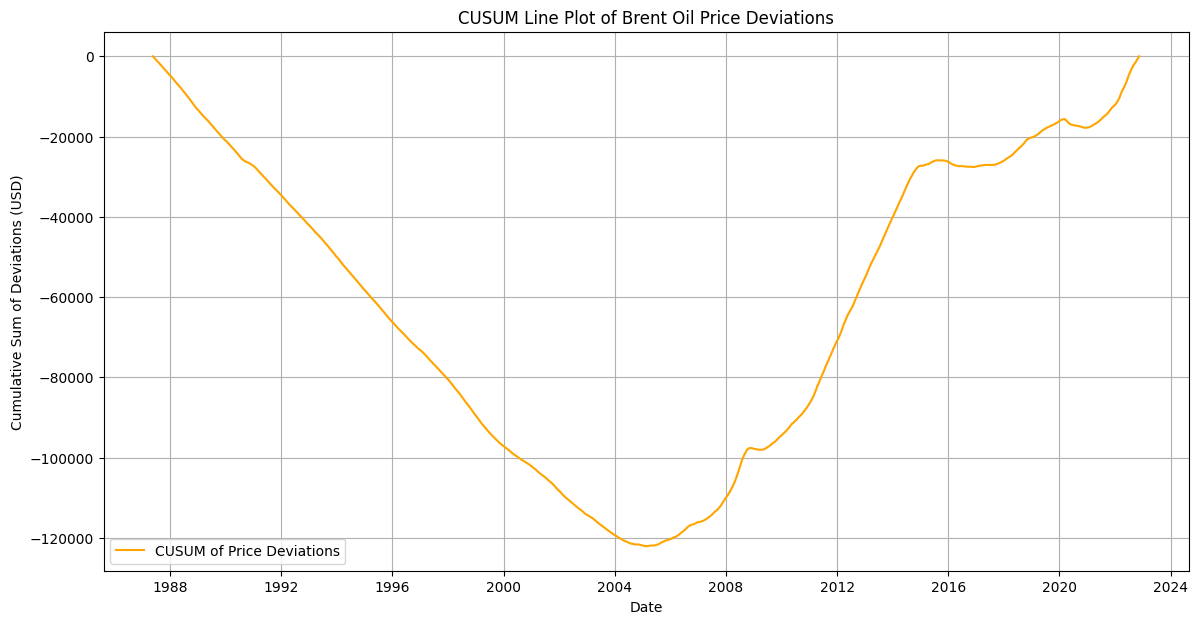

In [3]:
# Usage example
analyzer = EventChangeAnalyzer(price_data, logger=logger)
# Calculate CUSUM
analyzer.calculate_cusum()

# Event Impact Analysis
- Change Point Analysis
- Estimate Change Point
- Analyze the impact of Events on oil price

# Change Point Analysis

Detected change point years: [1999, 2004, 2010, 2014, 2021]


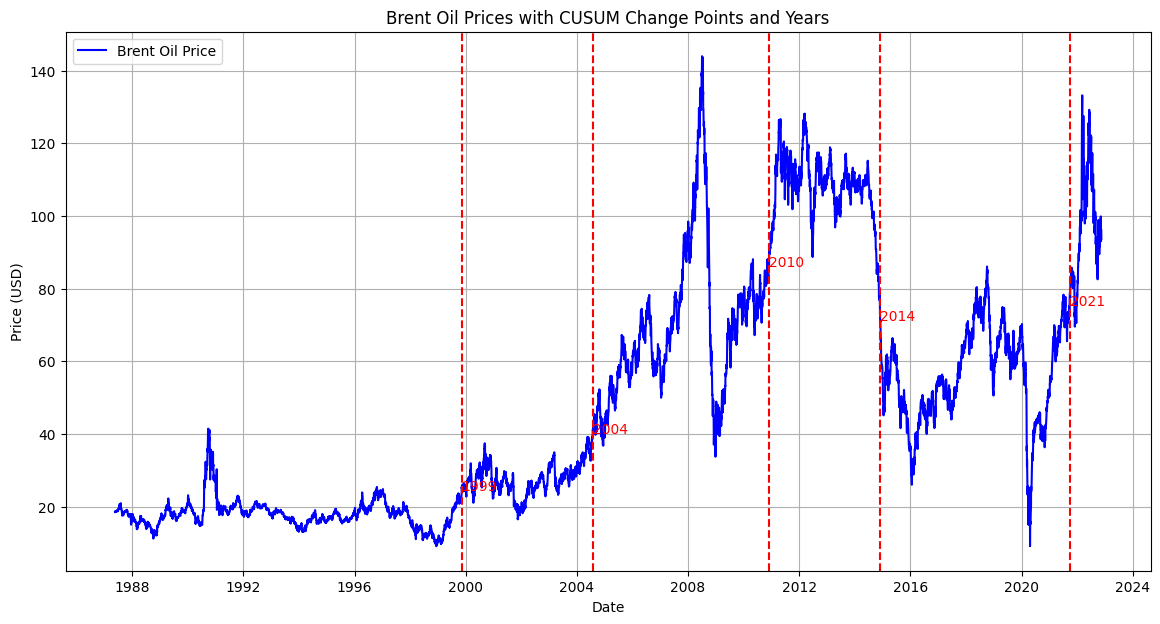

In [4]:
analyzer.detect_change_point()

# Estimate the change point 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [change_point]
>NUTS: [mu1, mu2, sigma1, sigma2]


/home/neba/Desktop/Data_Engineering/KAMI/Week-10/Brent-Time-Shift/.env/lib/python3.12/site-packages/rich/live.py:23
1: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


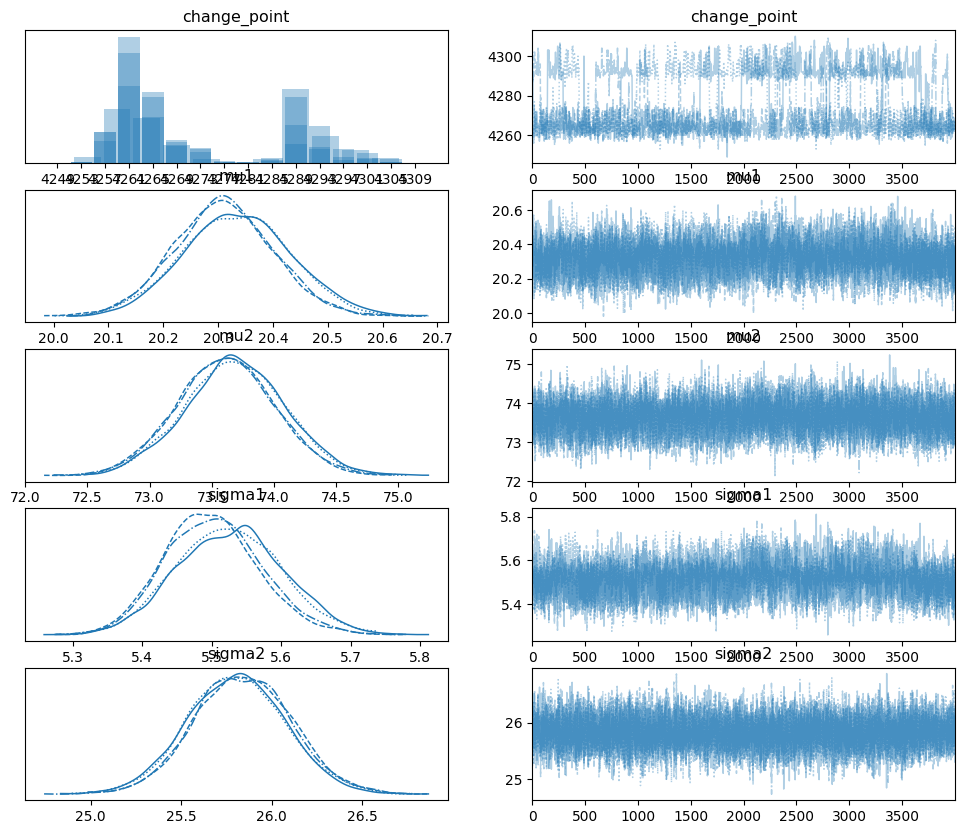

Estimated Change Point Date: 2004-03-04 00:00:00


In [5]:
change_point_date = analyzer.bayesian_change_point_detection()

**Based on the previous analysis on detecting the change points the following key events are identified that were impacted oil prices:**

- **1999 Russian Financial Crisis**: The Russian default on its debt and devaluation of the ruble in 1998 led to a sharp drop in oil prices, but by 1999, the recovery began as oil demand increased, particularly from Asia.

- **2005 Hurricane Katrina**: This devastating hurricane struck the Gulf Coast of the United States in August 2005, causing significant disruptions to oil production and refining capacity, leading to a spike in oil prices.

- **2010 Arab Spring**: The wave of protests and uprisings across the Arab world began in late 2010, leading to political instability in key oil-producing countries such as Libya and Egypt, which drove up Brent oil prices.

- **2014 Oil Price Crash**: In mid-2014, Brent oil prices began to decline sharply due to oversupply in the market, driven by increased production from the U.S. shale oil boom and OPEC's decision not to cut output.

- **2021 COVID-19 Pandemic Recovery**: As global economies began to reopen following lockdowns, demand for oil surged, contributing to significant price increases in 2021. Additionally, OPEC+ production cuts played a role in driving prices higher.

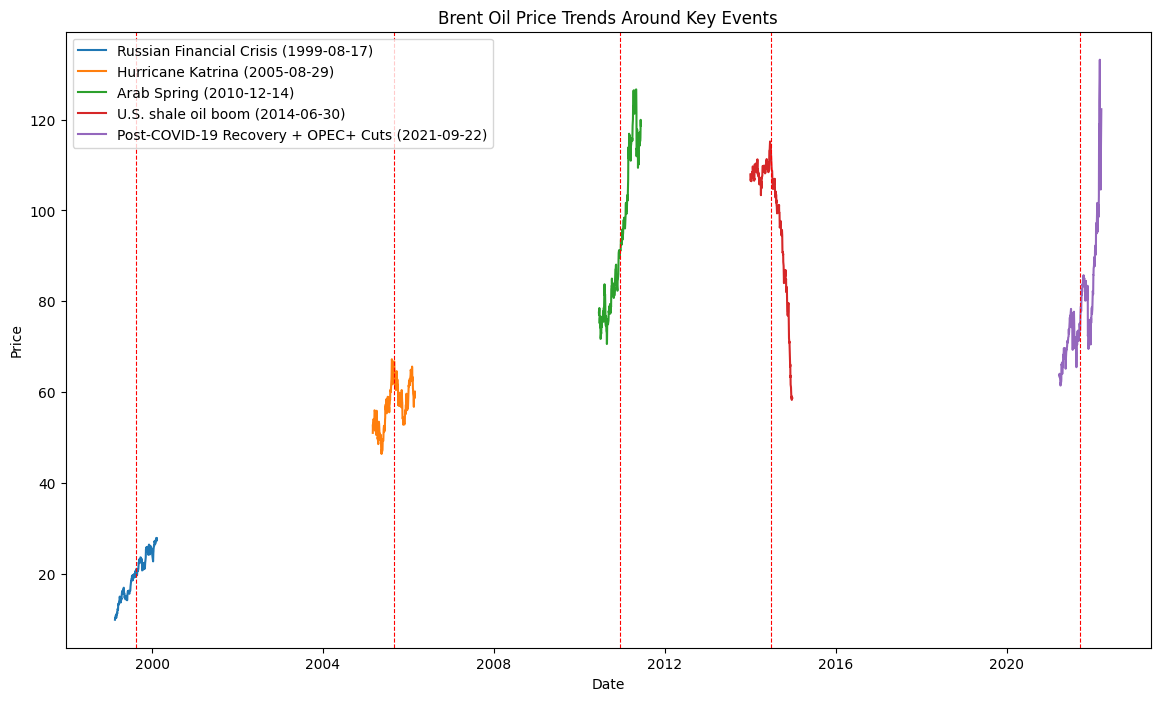

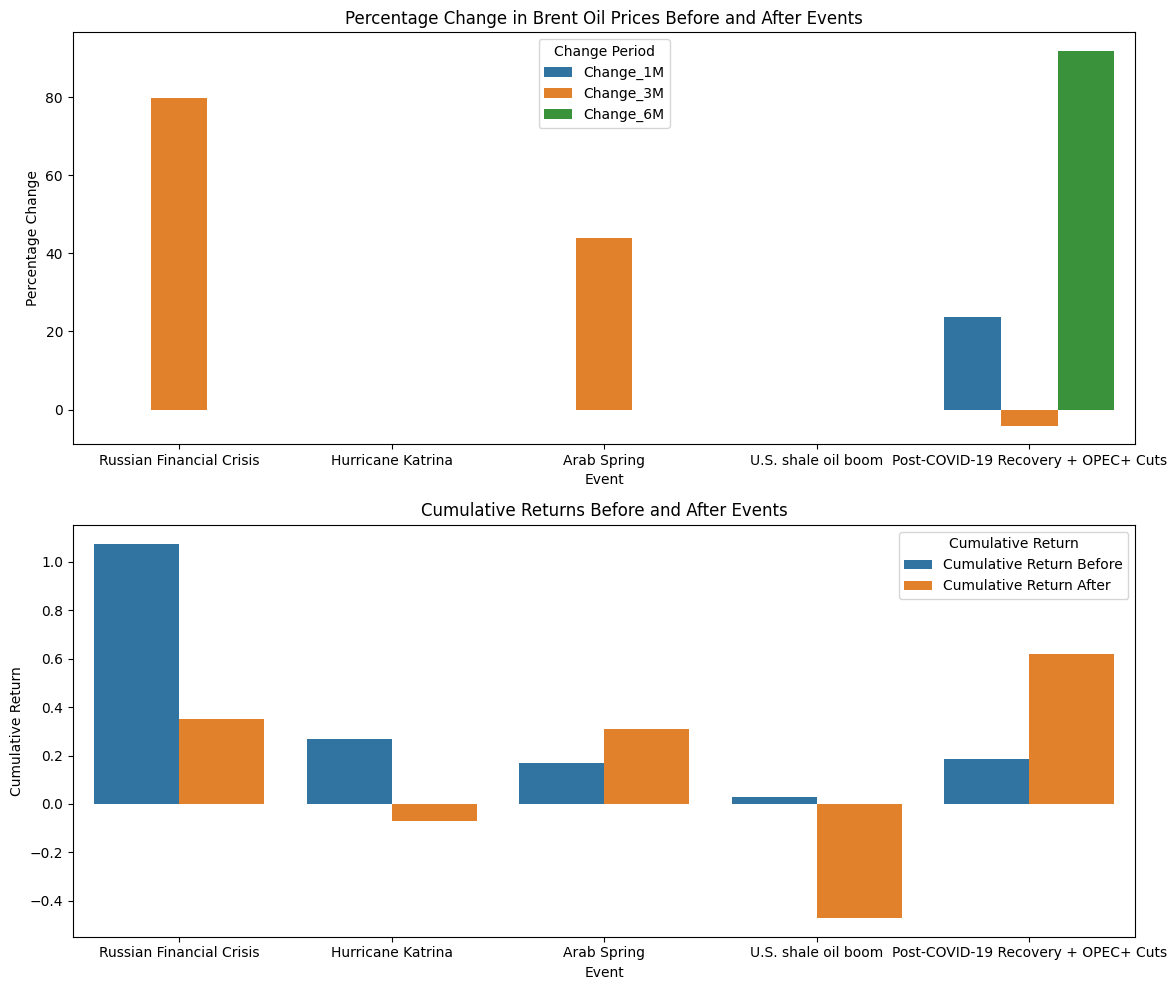

                                     t-statistic       p-value
Russian Financial Crisis              -25.682906  1.910203e-71
Hurricane Katrina                      -8.628759  6.872953e-16
Arab Spring                           -27.332285  1.677389e-76
U.S. shale oil boom                    14.154307  8.427530e-34
Post-COVID-19 Recovery + OPEC+ Cuts   -13.621948  5.968134e-32
Event Impact DataFrame:


,Event,Date,Change_1M,Change_3M,Change_6M,Cumulative Return Before,Cumulative Return After
0,Russian Financial Crisis,1999-08-17,NaN,79.819695,NaN,1.075529,0.349830
1,Hurricane Katrina,2005-08-29,NaN,NaN,NaN,0.268756,-0.071638
2,Arab Spring,2010-12-14,NaN,43.958705,NaN,0.169118,0.309831
3,U.S. shale oil boom,2014-06-30,NaN,NaN,NaN,0.028627,-0.471134
4,Post-COVID-19 Recovery + OPEC+ Cuts,2021-09-22,23.686116,-4.081633,91.767289,0.183942,0.619735



T-Test Results:


,t-statistic,p-value
Russian Financial Crisis,-25.682906,1.910203e-71
Hurricane Katrina,-8.628759,6.872953e-16
Arab Spring,-27.332285,1.677389e-76
U.S. shale oil boom,14.154307,8.427530e-34
Post-COVID-19 Recovery + OPEC+ Cuts,-13.621948,5.968134e-32


In [ ]:
# The researched key events associated with change points
key_events = {
    "Russian Financial Crisis": "1999-08-17",
    "Hurricane Katrina": "2005-08-29",
    "Arab Spring": "2010-12-14",
    "U.S. shale oil boom": "2014-06-30",
    "Post-COVID-19 Recovery + OPEC+ Cuts": "2021-09-22",
}
# Call the analyze_price_changes_around_events method
event_impact_df, t_test_df = analyzer.analyze_price_changes_around_events(key_events)

# Display results
print("Event Impact DataFrame:")
display(event_impact_df)

print("\nT-Test Results:")
display(t_test_df)

# Econometric Analysis
- Download Economic Indicators Dataset from World bank

In [7]:
import wbdata

def fetch_data(indicator_code, indicator_name, country='WLD', start_date=None, end_date=None):
    """Fetches data from World Bank Data for a specified indicator."""
    data = wbdata.get_dataframe({indicator_code: indicator_name}, country=country, date=(start_date, end_date))
    return data

def clean_data(df):
    """Cleans the DataFrame by resetting index, renaming columns, and handling missing values."""
    if df is not None and not df.empty:
        df.reset_index(inplace=True)
        df.columns = ['date', df.columns[1]]  # Keep the first column as 'date', second as the indicator name
        df.dropna(inplace=True)
        df['date'] = pd.to_datetime(df['date'])
        return df
    return pd.DataFrame()  # Return an empty DataFrame if input is None or empty

def convert_to_daily(df):
    """Converts a DataFrame with dates to a daily frequency."""
    full_index = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
    df_daily = df.set_index('date').reindex(full_index)
    df_daily.interpolate(method='time', inplace=True)  # Interpolate to fill missing values
    df_daily.reset_index(inplace=True)
    df_daily.rename(columns={'index': 'Date'}, inplace=True)
    return df_daily

# Set the indicator codes
gdp_indicator = 'NY.GDP.MKTP.CD'                # GDP (current US$)
cpi_indicator = 'FP.CPI.TOTL.ZG'                    # Inflation (CPI)
unemployment_indicator = 'SL.UEM.TOTL.ZS'        # Unemployment rate (% of total labor force)
exchange_rate_indicator = 'PA.NUS.FCRF'         # Exchange rate, USD to other currencies

# Define the date range
start_date = '1987-05-20'
end_date = '2022-11-14'

# Fetch and clean data for each indicator
gdp_data = clean_data(fetch_data(gdp_indicator, 'GDP', country='WLD', start_date=start_date, end_date=end_date))
cpi_data = clean_data(fetch_data(cpi_indicator, 'CPI', country='WLD', start_date=start_date, end_date=end_date))
unemployment_data = clean_data(fetch_data(unemployment_indicator, 'Unemployment Rate', country='WLD', start_date=start_date, end_date=end_date))
exchange_rate_data = clean_data(fetch_data(exchange_rate_indicator, 'Exchange Rate', country='EMU', start_date=start_date, end_date=end_date))

# Convert to daily frequency
gdp_data_daily = convert_to_daily(gdp_data)
cpi_data_daily = convert_to_daily(cpi_data)
unemployment_data_daily = convert_to_daily(unemployment_data)
exchange_rate_data_daily = convert_to_daily(exchange_rate_data)

# Save each cleaned DataFrame to a CSV file
gdp_data_daily.to_csv("../data/GDP_cleaned_data_daily.csv", index=False)
cpi_data_daily.to_csv("../data/CPI_cleaned_data_daily.csv", index=False)
unemployment_data_daily.to_csv("../data/Unemployment_Rate_cleaned_data_daily.csv", index=False)
exchange_rate_data_daily.to_csv("../data/Exchange_Rate_cleaned_data_daily.csv", index=False)

# Investigate relationships between econometric indicators and oil prices

Correlation between GDP and oil prices: 0.7567554273993586


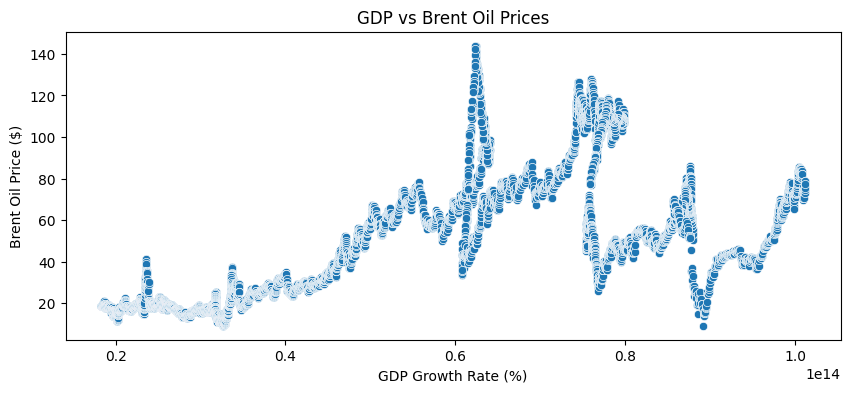

Correlation between CPI and oil prices: -0.40936074703516684


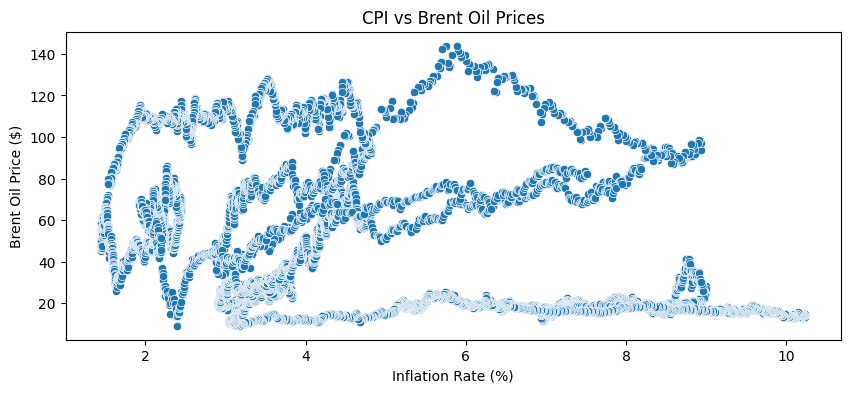

Correlation between Unemployment Rate and oil prices: 0.17293234258935586


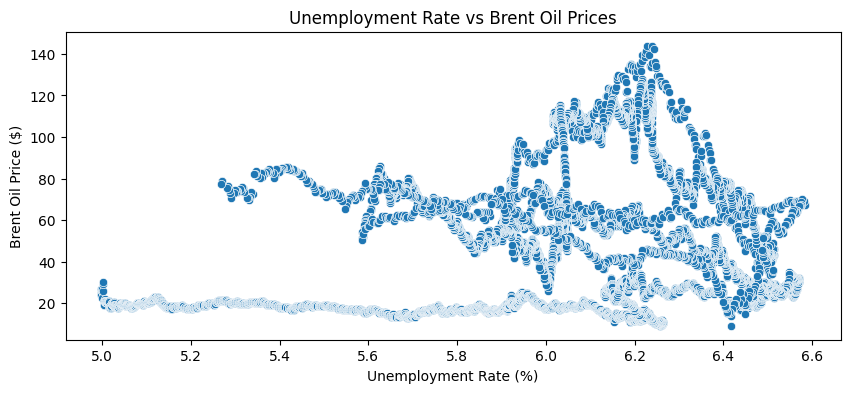

Correlation between Exchange Rate and oil prices: -0.6736337150209085


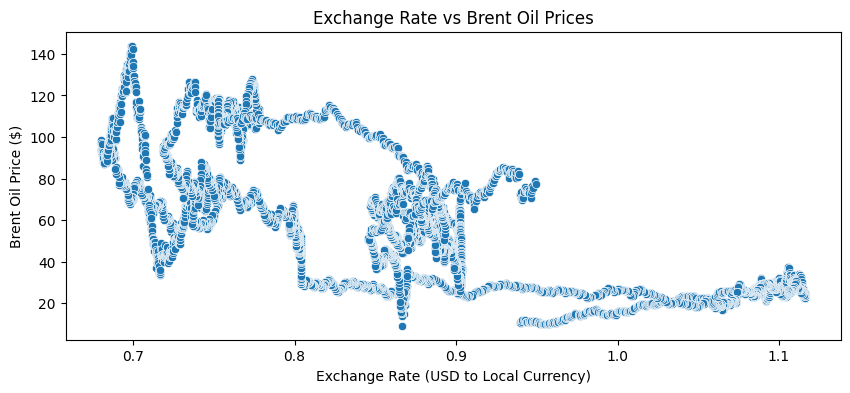

In [8]:
def analyze_indicators(gdp_data, inflation_data, unemployment_data, exchange_rate_data, oil_data):
    
    # Function to merge and analyze
    def analyze_and_plot(indicator_data, indicator_name, oil_data, x_label):
        merged_data = pd.merge(indicator_data, oil_data.reset_index(), on='Date')
        
        # Drop NaN values to ensure correlation calculation is valid
        merged_data.dropna(inplace=True)
        correlation = merged_data[indicator_name].corr(merged_data['Price'])
        print(f"Correlation between {indicator_name} and oil prices: {correlation}")

        # Scatter plot
        plt.figure(figsize=(10, 4))
        sns.scatterplot(data=merged_data, x=indicator_name, y='Price')
        plt.title(f'{indicator_name} vs Brent Oil Prices')
        plt.xlabel(x_label)
        plt.ylabel('Brent Oil Price ($)')
        plt.show()

    # Analyze GDP
    analyze_and_plot(gdp_data, 'GDP', oil_data, 'GDP Growth Rate (%)')

    # Analyze Inflation
    analyze_and_plot(inflation_data, 'CPI', oil_data, 'Inflation Rate (%)')

    # Analyze Unemployment
    analyze_and_plot(unemployment_data, 'Unemployment Rate', oil_data, 'Unemployment Rate (%)')

    # Analyze Exchange Rate
    analyze_and_plot(exchange_rate_data, 'Exchange Rate', oil_data, 'Exchange Rate (USD to Local Currency)')

analyze_indicators(gdp_data_daily, cpi_data_daily, unemployment_data_daily, exchange_rate_data_daily, price_data)

# Merge all datasets on 'Date' column

In [9]:
merged_data = (
    gdp_data_daily
    .merge(exchange_rate_data_daily, on='Date', how='outer')
    .merge(price_data.reset_index(), on='Date', how='outer')
)

# Fill missing values with forward fill for consistency if there are any gaps
merged_data.ffill(inplace=True)

# Save to csv file
merged_data.to_csv('../data/features.csv', index=False)

# Feature Engineering
- Generate new features from oil price data

In [10]:
# Load the the price dataset
merged_data = pd.read_csv('../data/features.csv')

# Create New Features from Oil Prices

In [11]:
# Percentage change
merged_data['Price_Pct_Change'] = merged_data['Price'].pct_change()

# Rolling averages (e.g., 7-day and 30-day moving averages)
merged_data['Price_7D_MA'] = merged_data['Price'].rolling(window=7).mean()
merged_data['Price_30D_MA'] = merged_data['Price'].rolling(window=30).mean()

# Rolling volatility (e.g., 7-day and 30-day standard deviation)
merged_data['Price_7D_Volatility'] = merged_data['Price'].rolling(window=7).std()
merged_data['Price_30D_Volatility'] = merged_data['Price'].rolling(window=30).std()

# Price momentum (e.g., 7-day and 30-day difference)
merged_data['Price_7D_Change'] = merged_data['Price'] - merged_data['Price'].shift(7)
merged_data['Price_30D_Change'] = merged_data['Price'] - merged_data['Price'].shift(30)

# Lagged Features
merged_data['Price_7D_Change'] = merged_data['Price'].diff(periods=7)
merged_data['Price_30D_Change'] = merged_data['Price'].diff(periods=30)
merged_data.dropna(inplace=True)
#merged_data.drop(columns=['Rolling_Volatility', 'Segment'], inplace=True)
features = merged_data.set_index('Date')

features

,GDP,Exchange Rate,Price,Price_Pct_Change,Price_7D_MA,Price_30D_MA,Price_7D_Volatility,Price_30D_Volatility,Price_7D_Change,Price_30D_Change
Date,,,,,,,,,,
1999-01-01,3.273100e+13,0.938283,10.54,0.000000,10.212857,9.804333,0.301591,0.411555,0.63,0.83
1999-01-02,3.273403e+13,0.938679,10.54,0.000000,10.302857,9.820667,0.289926,0.430909,0.63,0.49
1999-01-03,3.273707e+13,0.939074,10.54,0.000000,10.392857,9.847667,0.241365,0.449986,0.63,0.81
1999-01-04,3.274011e+13,0.939470,10.94,0.037951,10.540000,9.888000,0.209841,0.491398,1.03,1.21
1999-01-05,3.274315e+13,0.939866,10.30,-0.058501,10.550000,9.907000,0.193649,0.496075,0.07,0.57
...,...,...,...,...,...,...,...,...,...,...
2022-11-08,1.012251e+14,0.949624,96.85,-0.030239,96.575714,93.685333,2.394910,2.984813,2.21,10.88
2022-11-09,1.012251e+14,0.949624,93.05,-0.039236,96.540000,93.802000,2.453059,2.884312,-0.25,3.50
2022-11-10,1.012251e+14,0.949624,94.25,0.012896,96.415714,93.963333,2.556840,2.762986,-0.87,4.84


# Clean the data

In [12]:
# Copy your features DataFrame
data = features.copy()

# Ensure the date index is properly formatted
data.index = pd.to_datetime(data.index)

# Create a complete date range and reindex
full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data = data.reindex(full_date_range)

# Fill missing values using forward fill
data.ffill(inplace=True)  # This will fill NaNs with the last valid observation

# Now you can proceed with your train-validation-test split
train_size = int(len(data) * 0.8)  # Adjust split ratio for train
validation_size = int(len(data) * 0.1)  # Adjust split ratio for validation (10% of total)

# Define train, validation, and test sets
train = data.iloc[:train_size]
validation = data.iloc[train_size:train_size + validation_size]
test = data.iloc[train_size + validation_size:]

# Check for missing values after the split
print("Missing Values in Train:", train.isnull().sum())
print("Missing Values in Validation:", validation.isnull().sum())
print("Missing Values in Test:", test.isnull().sum())

# Optional: Print the sizes of the datasets
print(f"Train Size: {len(train)}")
print(f"Validation Size: {len(validation)}")
print(f"Test Size: {len(test)}")

Missing Values in Train: GDP                     0
Exchange Rate           0
Price                   0
Price_Pct_Change        0
Price_7D_MA             0
Price_30D_MA            0
Price_7D_Volatility     0
Price_30D_Volatility    0
Price_7D_Change         0
Price_30D_Change        0
dtype: int64
Missing Values in Validation: GDP                     0
Exchange Rate           0
Price                   0
Price_Pct_Change        0
Price_7D_MA             0
Price_30D_MA            0
Price_7D_Volatility     0
Price_30D_Volatility    0
Price_7D_Change         0
Price_30D_Change        0
dtype: int64
Missing Values in Test: GDP                     0
Exchange Rate           0
Price                   0
Price_Pct_Change        0
Price_7D_MA             0
Price_30D_MA            0
Price_7D_Volatility     0
Price_30D_Volatility    0
Price_7D_Change         0
Price_30D_Change        0
dtype: int64
Train Size: 6975
Validation Size: 871
Test Size: 873
